<h1 style = 'text-align: center'> <b>Week 05: Machine Learning For NLP</b> </h1>

- Full name: Võ Nguyễn Hoàng Kim

- Mentee ID: 240103

In [25]:
!pip install underthesea
import pandas as pd
import numpy as np
import os

import re
import underthesea
from underthesea import word_tokenize
from underthesea import text_normalize
from gensim.models import Word2Vec

import seaborn as sns
import matplotlib.pyplot as plt



import sklearn

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB, GaussianNB 

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler




# <b>1. Read Data</b>

In [26]:
# read data

data_path = '/kaggle/input/vietnamese-text-classification-dataset/train.csv'

stopwords_path = "/kaggle/input/vietnamese-stop-words/vietnamese-stopwords.txt"



def read_input_data(data_path, stopwords_path):

    # input data (text)

    data = pd.read_csv(data_path, names = ['labels', 'text', 'tokens'])    # stop words

    with open(stopwords_path) as f:

        stop_words = f.read()

    return (data, stop_words)



df, stop_words = read_input_data(data_path, stopwords_path)

# <b>2. Preprocessing Text</b>

In [27]:
# normalize text 

def normalizeText(article):

    return text_normalize(article)


# remove unnecessary punctuation 

def cleanText(article):    
    # remove several punctuation such as ; , ( ) [ ] ... 
    return re.sub(r'[^\w\s/:.-]', '', article)


# remove stop word

def removeStopWords(article, stop_words):

    # using regex with re.sub to remove stop word (better than using String replace)

    stop_words_pattern = r'\b(?:' + '|'.join(map(re.escape, stop_words)) + r')\b'

    cleaned_text = re.sub(stop_words_pattern, ' ', article)

    # remove redundant spaces

    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text



# tokenize by underthesea

def tokenization(article):

    return word_tokenize(article)



def preprocessText(articles_content, stop_words):

    processed_articles = []

    for article in articles_content:

        # lower case

        article = article.lower()

        # normalize text

        normalized_text = normalizeText(article)

        # remove stop words

        removedStopWords_text = removeStopWords(normalized_text, stop_words)

        # tokenize text

        tokens = tokenization(removedStopWords_text)        

        # re-clean tokens to remove unnecessary characters like '-', '.', etc.

        cleaned_tokens = [token for token in tokens if re.search(r'[a-zA-Z0-9]', token)]

        # add tokens in result list

        processed_articles.append(cleaned_tokens)

    return processed_articles



df['tokens'] = preprocessText(df['text'], stop_words)



df.head(10)

,labels,text,tokens
0,0,máy dùng hay bị đơ máy,"[máy, dùng, hay, bị, máy]"
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...,"[chỉ, có, dây cáp, nguồn, không, có, adapter, ..."
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...,"[chất lượng, quá, kém, mới, dùng, được, 2, ngà..."
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...,"[usb, tôi, vừa mới, nhận, usb, này, rất, bực b..."
4,2,Tuyệt vời. Hàng FPT cửa hàng,"[tuyệt vời, hàng, fpt, cửa hàng]"
5,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...,"[chưa, đo, đúng, bước, chân, rõ, nhiều, khi, g..."
6,0,phủ sóng thấp quá đi khoảng 3 4m là mất sóng,"[phủ sóng, thấp, quá, đi, khoảng, 3, 4, là, mấ..."
7,1,Kết nối tốt Mối nối không khít gây đau tai 1 K...,"[kết nối, tốt mối, nối, không, khít, gây, đau ..."
8,0,2 Loa nhỏ nghe bị rè Âm thanh chưa tốt hơi thấ...,"[2, loa, nhỏ, nghe, bị, rè, âm thanh, chưa, tố..."
9,0,Đặt i12 shop giao i11 thất vọng,"[đặt, i12, shop, giao i11, thất vọng]"


# <b>3. SVM + Word2Vec</b>

In [28]:
def vectorize_sentence(sentence, model):

    try:

        # vectorize all words in a sentence

        word_vectors = model.wv[sentence]

        # calculate the mean of the word vectors (avg word2vec)

        return np.mean(word_vectors, axis = 0)

    except KeyError:

        return np.zeros(model.vector_size)

In [29]:
model_word2vec = Word2Vec(sentences = df['tokens'], vector_size = 100, window = 5, min_count = 1, workers = 4)

scaler = MinMaxScaler(feature_range=(0, 1))



X = scaler.fit_transform(np.array([vectorize_sentence(sentence, model_word2vec) for sentence in df['tokens']]))

y = np.array(df['labels'])



# split into train & test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
# survey hyper-parameters in model

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernels:

    clf = SVC(kernel=kernel)

    scores = cross_val_score(clf, X_train, y_train, cv=5)

    print(f"Kernel: {kernel}, Accuracy: {np.mean(scores):.4f}")



param_grid = {

    'C': [1.0, 10.0, 100.0, 1000.0],

    'gamma': [0.01, 0.1, 1, 'scale', 'auto']

}



model = SVC(kernel = 'rbf')



grid_search = GridSearchCV(model, param_grid, cv= 5, scoring='accuracy')



grid_search.fit(X_train, y_train)



print("Best parameters: ", grid_search.best_params_)

print("Best Cross-Validation score: ", grid_search.best_score_)

Kernel: linear, Accuracy: 0.6575
Kernel: poly, Accuracy: 0.7286
Kernel: rbf, Accuracy: 0.6299
Kernel: sigmoid, Accuracy: 0.3553
Best parameters:  {'C': 1000.0, 'gamma': 0.1}
Best Cross-Validation score:  0.7339510397917881


Accuracy:  0.75
Classification report
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       241
           1       0.64      0.59      0.62       175
           2       0.80      0.79      0.80       192

    accuracy                           0.75       608
   macro avg       0.74      0.74      0.74       608
weighted avg       0.75      0.75      0.75       608



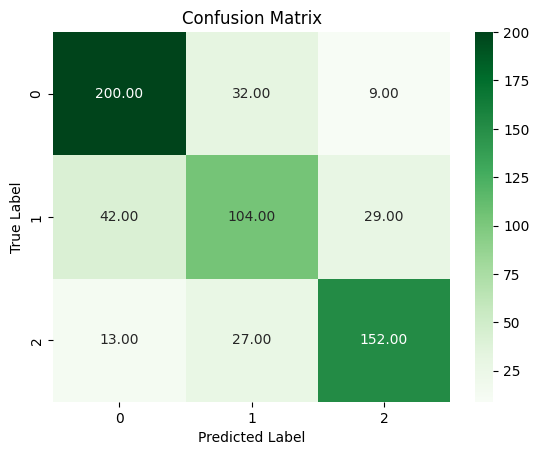

In [31]:
# train SVM model

classifier = SVC(kernel = 'poly')

classifier.fit(X_train, y_train)



y_pred = classifier.predict(X_test)



print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Classification report\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".2f", cmap="Greens")

plt.title("Confusion Matrix")

plt.xlabel("Predicted Label")

plt.ylabel("True Label")

plt.show()

# <b>4. Naive Bayes with Word2Vec</b>

In [32]:
model_word2vec = Word2Vec(sentences = df['tokens'], vector_size = 100, window = 5, min_count = 1, workers = 4)

scaler = MinMaxScaler(feature_range=(0, 1))



X = scaler.fit_transform(np.array([vectorize_sentence(sentence, model_word2vec) for sentence in df['tokens']]))

y = np.array(df['labels'])



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Accuracy: 0.5641447368421053
              precision    recall  f1-score   support

           0       0.55      0.87      0.67       241
           1       1.00      0.01      0.01       175
           2       0.59      0.69      0.63       192

    accuracy                           0.56       608
   macro avg       0.71      0.52      0.44       608
weighted avg       0.69      0.56      0.47       608



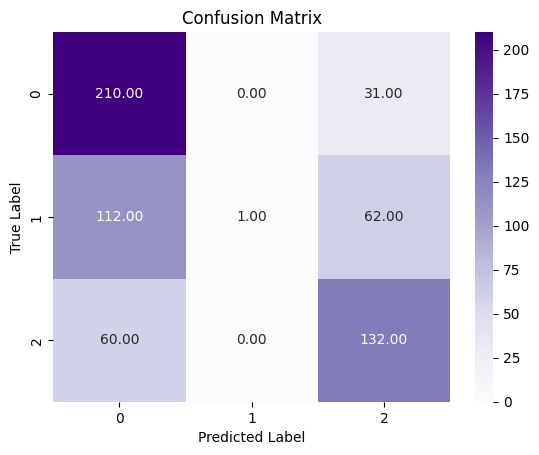

In [33]:
# Train the Naive Bayes model

model_nb = MultinomialNB()

model_nb.fit(X_train, y_train)

y_pred = model_nb.predict(X_test)



# Evaluate the model

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".2f", cmap="Purples")

plt.title("Confusion Matrix")

plt.xlabel("Predicted Label")

plt.ylabel("True Label")

plt.show()

# <b>5. Naive Bayes with TF-IDF</b>

In [34]:
# vectorize by TF-IDF

tfidf_vectorizer = TfidfVectorizer()

X = tfidf_vectorizer.fit_transform(df['tokens'].apply(lambda x: " ".join(x)))

y = df['labels']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Accuracy:  0.7845394736842105
Classification report
               precision    recall  f1-score   support

           0       0.81      0.86      0.84       241
           1       0.76      0.54      0.63       175
           2       0.77      0.91      0.83       192

    accuracy                           0.78       608
   macro avg       0.78      0.77      0.77       608
weighted avg       0.78      0.78      0.78       608



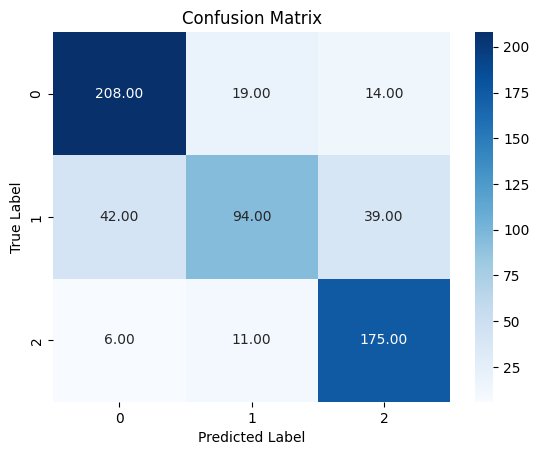

In [35]:
model_NB = MultinomialNB()

model_NB.fit(X_train, y_train)



y_pred = model_NB.predict(X_test)



print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Classification report\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".2f", cmap="Blues")

plt.title("Confusion Matrix")

plt.xlabel("Predicted Label")

plt.ylabel("True Label")

plt.show()